### Imports, device calibration and plot manifesting

In [1]:
import torch
import torch.cuda
import torch.nn.functional as F
from torch import nn as nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score,  accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
### For importing/extracting figures to the thesis ###

import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 500
plt.rcParams.update({
    'font.size'         : 15,
    'axes.titlesize'    : 22,
    'axes.labelsize'    : 22,
    'xtick.labelsize'   : 22,
    'ytick.labelsize'   : 22,
})

save_path = 'C:/Users/loren/OneDrive - University of Bergen/Masterbby/latex/figures'

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() 
          else torch.device('cpu'))

print(f"Training on device {device}.")

seed = 44

def set_seed(seed=seed):
    torch.manual_seed(seed=seed)
    # For multi-GPU setups:
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed=seed)
        print('CUDA is available')
        
if __name__ == "__main__":
    set_seed(seed=seed)

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
np.random.seed(seed)

Training on device cuda.
CUDA is available


### Data Loading and exploration

In [3]:
data_path = 'Resultat_deeplearning2.xlsx'

def load_data(data_path, augment=False):
    df = pd.read_excel(data_path, sheet_name='deep')
    df = df.iloc[0:618, 0:46]

    df = df.drop(columns=['REMOVE', 'REMOVE2', 'ChemShift_MP', 'PeakArea_MP', 'Ampl_MP', 'AmplStd_MP',# 'ChemShift_GPE', 'PeakArea_GPE', 'Ampl_GPE', 'AmplStd_GPE', 
                      #  'ChemShift_PE', 'PeakArea_PE', 'Ampl_PE', 'AmplStd_PE', 'ChemShift_PC', 'PeakArea_PC', 'Ampl_PC', 'AmplStd_PC', 'Series',
                        'ChemShift_GPC', 'PeakArea_GPC', 'Ampl_GPC', 'AmplStd_GPC', 'METAMUS'], axis=1) 
    df = df.dropna()
    
    #df = df[~df['Stimuli'].str.contains("rest|visual", case=False)]
    x = df.drop('Stimuli', axis=1)

    y = df['Stimuli']

    if augment == True:
      X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.6, random_state=seed, shuffle=True, stratify=y)

      X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, shuffle=True, stratify=y_temp)
      
    else:
      X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True, stratify=y)
    
      X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=seed, shuffle=True, stratify=y_trainval)


    return X_train, X_test, X_val,  y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, augment=False)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 370 samples
Validation set: 124 samples
Test set: 124 samples


In [4]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

Stimuli
visual    94
heroic    93
rest      93
sad       90
Name: count, dtype: int64
Stimuli
rest      32
visual    31
heroic    31
sad       30
Name: count, dtype: int64
Stimuli
heroic    32
rest      31
visual    31
sad       30
Name: count, dtype: int64


In [5]:
cols_to_convert = [
    'ChemShift_ATP_B',
    'ChemShift_ATP_ALPHA',
    'ChemShift_ATP_GAMMA1',
    'ChemShift_PCR',
    'ChemShift_PI',
    'ChemShift_PC',
    'ChemShift_PE',
    'ChemShift_GPE',
    'Series']

for col in cols_to_convert:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')


## Preprocessing

In [6]:
#Label encoding and feature selection
label_encoder = LabelEncoder()

# Fit and transform the y data
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)


num_classes = int(np.max(y_train_encoded)) + 1

y_train_onehot = F.one_hot(torch.tensor(y_train_encoded, dtype=torch.long), num_classes=num_classes).float().to(device)
y_test_onehot  = F.one_hot(torch.tensor(y_test_encoded, dtype=torch.long), num_classes=num_classes).float().to(device)
y_val_onehot   = F.one_hot(torch.tensor(y_val_encoded, dtype=torch.long), num_classes=num_classes).float().to(device)


In [7]:
#Scale the Data

#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = MaxAbsScaler()
scaler = MinMaxScaler()  
#scaler = Normalizer()  

# Select only numeric columns from the data (effectively removes column headers)
X_train_numeric = X_train.select_dtypes(include=[float,int])
X_test_numeric = X_test.select_dtypes(include=[float,int])
X_val_numeric = X_val.select_dtypes(include=[float,int])

scaler.fit(X_train_numeric)


X_train_scaled = scaler.transform(X_train_numeric)
X_val_scaled = scaler.transform(X_val_numeric)
X_test_scaled = scaler.transform(X_test_numeric)


print("Train set:", X_train_numeric.shape)
print("Validation set:", X_val_numeric.shape)
print("Test set:", X_test_numeric.shape)

print("Train set:", X_train_scaled.shape)
print("Validation set:", X_val_scaled.shape)
print("Test set:", X_test_scaled.shape)



Train set: (370, 34)
Validation set: (124, 34)
Test set: (124, 34)
Train set: (370, 34)
Validation set: (124, 34)
Test set: (124, 34)


In [ ]:
def augment_mixup(X, y, alpha=0.2, augment_ratio=0.5, seed=44, device=device):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device is None:
        device = torch.device("cpu")


    # Convert inputs to torch tensors (if not already) and move to device.
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32, device=device)
    else:
        X = X.to(device)
        
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, device=device, dtype=torch.long)
    else:
        y = y.to(device, dtype=torch.long)
    
    N = X.size(0)
    num_aug = int(N * augment_ratio)

    

    # Determine the number of classes and convert y to one-hot encoding.
    num_classes = int(torch.max(y).item()) + 1
    y_onehot = F.one_hot(y, num_classes=num_classes).float()

    # Set seed if provided for reproducibility.
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # Randomly select indices for pairing.
    indices1 = torch.randint(0, N, (num_aug,), device=device)
    indices2 = torch.randint(0, N, (num_aug,), device=device)
    
    # Sample mixing coefficients from the Beta distribution.
    beta_dist = torch.distributions.Beta(alpha, alpha)
    lam = beta_dist.sample((num_aug,)).to(device)  
    lam = lam.view(-1, 1)  
    
    # Create new features and labels by linearly interpolating between pairs.
    X1 = X[indices1]
    X2 = X[indices2]
    new_X = lam * X1 + (1 - lam) * X2
    
    y1 = y_onehot[indices1]
    y2 = y_onehot[indices2]
    new_y = lam * y1 + (1 - lam) * y2
    
    # Optionally, combine augmented samples with the original data.
    X_combined = torch.cat([X, new_X], dim=0)
    y_combined = torch.cat([y_onehot, new_y], dim=0)
    
    return X_combined, y_combined

In [ ]:
def train_val_test_loader(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=256, aug=False, seed=seed):
    np.random.seed(seed)
    if aug==True:
        X_train_tensor, y_train_tensor = augment_mixup(X_train, y_train, alpha=0.2, augment_ratio=0.5, seed=seed, device=device)
    else:
        if not isinstance(X_train, torch.Tensor):
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        else:
            X_train_tensor = X_train

    if isinstance(y_train, torch.Tensor):
        y_train_tensor = y_train  
    else:
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    
    if isinstance(y_val, torch.Tensor):
        y_val_tensor = y_val
    else:
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    if isinstance(y_test, torch.Tensor):
        y_test_tensor = y_test
    else:
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset     = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset    = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader     = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader    = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    print("X_train_tensor:", X_train_tensor.shape)
    print("y_train_tensor:", y_train_tensor.shape)
    print("X_val_tensor:", X_val_tensor.shape)
    print("y_val_tensor:", y_val_tensor.shape)
    print("X_test_tensor:", X_test_tensor.shape)
    print("y_test_tensor:", y_test_tensor.shape)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = train_val_test_loader(X_train_scaled, X_val_scaled, X_test_scaled, 
                                                              y_train_onehot, y_val_onehot, y_test_onehot, batch_size=64, aug=False, seed=seed) #har hatt batch på 64


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32) #to set the input size of our models

X_train_tensor: torch.Size([370, 34])
y_train_tensor: torch.Size([370, 4])
X_val_tensor: torch.Size([124, 34])
y_val_tensor: torch.Size([124, 4])
X_test_tensor: torch.Size([124, 34])
y_test_tensor: torch.Size([124, 4])


## Models

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim = X_train_tensor.shape[1] , hidden_dim =128, output_dim= len(label_encoder.classes_)):
        super(SimpleNN, self).__init__()
        self.name = "SimpleNN"

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_name(self):
        return self.name
    
    def get_init_params(self):
        return {'input_dim': X_train_tensor.shape[1], 'hidden_dim': 128, 'output_dim': len(label_encoder.classes_)}

In [10]:
class AdvancedMLP(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1], num_classes=4, hidden_dim=128, dropout_p=0.3):
        super(AdvancedMLP, self).__init__()
        self.name = "AdvancedMLP"

        # First dense block
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.drop1 = nn.Dropout(p=dropout_p)

        # Second dense block
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.drop2 = nn.Dropout(p=dropout_p)

        # Attention layer
        self.attn = nn.Linear(hidden_dim, hidden_dim)

        # Third dense block
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.drop3 = nn.Dropout(p=dropout_p)

        # Output layer
        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def get_name(self):
        return self.name
    
    def get_init_params(self):
        return {'input_dim': X_train_tensor.shape[1], 'num_classes': 4, 'hidden_dim': 128, 'dropout_p': 0.3}

    def forward(self, x):
        # First dense block
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.drop1(x)

        # Second dense block
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.drop2(x)

        # Attention mechanism
        attn_weights = torch.sigmoid(self.attn(x))
        x = x * attn_weights

        # Third dense block
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.drop3(x)

        # Output layer
        logits = self.fc_out(x)
        return logits

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1], num_classes=4):
        super(MLP, self).__init__()
        self.name = "MLP"

        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=0.1)
        
        self.attn = nn.Linear(128, 128)

        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(128, num_classes)
    def get_name(self):
        return self.name
    
    def get_init_params(self):
        return {'input_dim': X_train_tensor.shape[1], 'num_classes': 4}
    
    def forward(self, x):
            # First Dense block
            x = F.relu(self.fc1(x))
            x = self.bn1(x)
            x = self.dropout1(x)
            

            attn_weights = torch.sigmoid(self.attn(x))  # shape: [batch_size, 128]
            x = x * attn_weights                         
            
            # Second Dense block
            x = F.relu(self.fc2(x))
            x = self.bn2(x)
            x = self.dropout2(x)
            
            # Output logits
            logits = self.fc3(x)
            
            # Return probability distribution over 4 classes
            return logits

In [12]:
class ComplexMLP(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1] , num_classes=4, hidden_dim=128, dropout_p=0.3):
        super(ComplexMLP, self).__init__()
        self.name = "ComplexMLP"

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.attn1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p=dropout_p)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.attn2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(p=dropout_p)

        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def get_name(self):
        return self.name
    
    def get_init_params(self):
        return {'input_dim': X_train_tensor.shape[1], 'num_classes': 4, 'hidden_dim': 128, 'dropout_p': 0.3}
    
    def forward(self, x):

        out1 = F.relu(self.fc1(x))       # shape: [batch_size, hidden_dim]
        out1 = self.bn1(out1)

        attn_weights1 = torch.sigmoid(self.attn1(out1))
        out1 = out1 * attn_weights1
        out1 = self.dropout1(out1)
        

        out2 = F.relu(self.fc2(out1))    # shape: [batch_size, hidden_dim]
        out2 = self.bn2(out2)
      
        attn_weights2 = torch.sigmoid(self.attn2(out2))
        out2 = out2 * attn_weights2
        out2 = self.dropout2(out2)

        out2 = out2 + out1
        
        out3 = F.relu(self.fc3(out2))
        out3 = self.bn3(out3)
        out3 = self.dropout3(out3)
        
        logits = self.fc_out(out3)
        return logits


In [13]:
### MLP with Attention ###
class AttentionLayer(nn.Module):
    def __init__(self, input_dim = X_train_tensor.shape[1]):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(input_dim, input_dim))
        self.b = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.b)

    def forward(self, x):
        """
        x shape: (batch_size, input_dim)
        """
        logits = x @ self.W + self.b

        alphas = F.softmax(logits, dim=1)


        out = x * alphas

        return out

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim = X_train_tensor.shape[1], num_classes=4):
        super().__init__()
        self.name = "MLPWithAttention"
       
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.3)

        self.attn = AttentionLayer(128)

        self.fc3 = nn.Linear(128, 128)

        self.fc_out = nn.Linear(128, num_classes)
    
    def get_name(self):
        return self.name
    
    def get_init_params(self):
        return {'input_dim': X_train_tensor.shape[1], 'num_classes': 4}
    
    def forward(self, x):
        """
        x shape: (batch_size, input_dim)
        Returns logits of shape (batch_size, num_classes).
        """
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.drop2(x)

        x = self.attn(x)

        x = F.relu(self.fc3(x))

        logits = self.fc_out(x)
        return logits

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, dim = X_train_tensor.shape[1]):
        super().__init__()
        self.name = "ResidualBlock"
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
    
    def get_name(self):
        return self.name
    
    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.fc1(x)))

        out = self.bn2(self.fc2(out))

        out = out + identity
        out = F.relu(out)
        return out

class DeepResidualMLP(nn.Module):
    def __init__(self, input_dim = X_train_tensor.shape[1], hidden_dim=128, num_classes=4, num_res_blocks=3):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.bn_in = nn.BatchNorm1d(hidden_dim)
        self.name = "DeepResidualMLP"

        self.res_blocks = nn.ModuleList(
            [ResidualBlock(hidden_dim) for _ in range(num_res_blocks)]
        )
        
        self.fc_out = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn_in(self.fc_in(x)))
        
        for block in self.res_blocks:
            x = block(x)

        logits = self.fc_out(x)
        return logits
    
    def get_name(self):
        return self.name
    
    def get_init_params(self):
        return {'input_dim': X_train_tensor.shape[1], 'hidden_dim': 128, 'num_classes': 4, 'num_res_blocks': 3}

### Train

In [15]:
def train(model, optimizer, criterion, train_loader, validation_loader, epochs):
    model.to(device)
    training_losses = []
    validation_losses = []
    accs = []
    f_scores = []
    combined_scores = []
    best_val_comb = 0
    best_epoch = 0

    for epoch in range(1, epochs + 1):
        model.train()
        training_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)  # Expected shape: (batch_size, num_classes)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        avg_training_loss = training_loss / len(train_loader)
        training_losses.append(avg_training_loss)
        
        model.eval()
        validation_loss = 0
        correct_predictions = 0
        total_predictions = 0
        all_targets = []
        all_predictions = []
        
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                validation_loss += loss.item()
                
                # Convert one-hot targets to class indices.
                _, predicted = torch.max(outputs, 1)
                true_labels = torch.argmax(target, dim=1)
                correct_predictions += (predicted == true_labels).sum().item()
                total_predictions += target.size(0)
                all_targets.extend(true_labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
        avg_validation_loss = validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)
        val_accuracy = correct_predictions / total_predictions * 100
        accs.append(val_accuracy)
        val_f1 = f1_score(all_targets, all_predictions, average='weighted') * 100
        f_scores.append(val_f1)
        combined = (val_accuracy + val_f1) / 2
        combined_scores.append(combined)
        
        if combined > best_val_comb:
            best_val_comb = combined
            best_epoch = epoch
            torch.save(model.state_dict(), f"{model.get_name()}_best_model_noaug.pth")
        
        if epoch == 1 or epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {avg_training_loss:.4f}, Val Loss: {avg_validation_loss:.4f}, '
                  f'Val Acc: {val_accuracy:.2f}%, F1: {val_f1:.2f}%, Combined: {combined:.2f}%')
    
    model.load_state_dict(torch.load(f"{model.get_name()}_best_model_noaug.pth"))
    best_model_summary = {
        'model_name': model.get_name(),
        'epoch': best_epoch,
        'accuracy': accs[best_epoch-1],
        'f1_score': f_scores[best_epoch-1],
        'combined_scores': combined_scores[best_epoch-1],
        'state_dict_path': f"{model.get_name()}_best_model_noaug.pth",
        'model_init_params': model.get_init_params()
    }
    
    return {
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'validation_accuracy': accs,
        'validation_f1_scores': f_scores,
        'best_model_summary': best_model_summary
    }


In [16]:
def test_model(model, test_loader, criterion):
    all_labels = []
    all_preds = []
    loss_logger = []
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            loss_logger.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            true_labels = torch.argmax(target, dim=1)
            correct_predictions += (predicted == true_labels).sum().item()
            total_predictions += target.size(0)
            
            all_labels.extend(true_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        acc = correct_predictions / total_predictions * 100
    return loss_logger, acc, all_labels, all_preds

In [ ]:
models = [SimpleNN(), MLP(), ComplexMLP(), AdvancedMLP(), DeepResidualMLP(), MLPWithAttention()]

epochs = 60
weight_decay = 0.001
lr = 0.1


criterion = nn.CrossEntropyLoss()


training_losses = []  
validation_losses = []
validation_accs = []
f1_scores = []
best_models = []

for model in models:
    print('Model:', model.get_name())
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
    results = train(
        model=model, 
        epochs=epochs, 
        criterion=criterion, 
        optimizer=optimizer, 
        train_loader=train_loader, 
        validation_loader=val_loader
    )
    training_losses.append(results['training_losses'])
    validation_losses.append(results['validation_losses'])
    validation_accs.append(results['validation_accuracy'])
    f1_scores.append(results['validation_f1_scores'])
    best_models.append(results['best_model_summary'])

Model: SimpleNN
Epoch: 1, Train Loss: 1.3906, Val Loss: 1.3992, Val Acc: 20.97%, F1: 13.79%, Combined: 17.38%
Epoch: 20, Train Loss: 1.3449, Val Loss: 1.3867, Val Acc: 28.23%, F1: 24.82%, Combined: 26.52%
Epoch: 40, Train Loss: 1.2701, Val Loss: 1.4449, Val Acc: 27.42%, F1: 25.80%, Combined: 26.61%
Epoch: 60, Train Loss: 1.1758, Val Loss: 1.6503, Val Acc: 27.42%, F1: 24.49%, Combined: 25.95%
Model: MLP
Epoch: 1, Train Loss: 1.5475, Val Loss: 1.3903, Val Acc: 25.00%, F1: 14.93%, Combined: 19.96%
Epoch: 20, Train Loss: 1.0181, Val Loss: 7.9871, Val Acc: 30.65%, F1: 30.48%, Combined: 30.56%
Epoch: 40, Train Loss: 0.4697, Val Loss: 7.1122, Val Acc: 32.26%, F1: 32.04%, Combined: 32.15%
Epoch: 60, Train Loss: 0.4160, Val Loss: 6.4374, Val Acc: 33.06%, F1: 32.67%, Combined: 32.87%
Model: ComplexMLP
Epoch: 1, Train Loss: 1.5761, Val Loss: 1.3804, Val Acc: 20.97%, F1: 15.27%, Combined: 18.12%
Epoch: 20, Train Loss: 1.1812, Val Loss: 1.6588, Val Acc: 24.19%, F1: 24.35%, Combined: 24.27%
Epoch: 4

In [18]:
best_modelss= max(best_models, key=lambda x: x['combined_scores'])

print(f"Model: {best_modelss['model_name']}")
print(f"Epoch: {best_modelss['epoch']}")
print(f"Accuracy: {best_modelss['accuracy']:.2f}%")
print(f"F1 Score: {best_modelss['f1_score']:.2f}%")
print(f"Combined Metric: {best_modelss['combined_scores']:.2f}%")


print("\n--- Combined Metrics for All Models ---")
for model in best_models:
    print(f"Model: {model['model_name']}, Combined Metric: {model['combined_scores']:.2f}%")

Model: DeepResidualMLP
Epoch: 40
Accuracy: 41.94%
F1 Score: 41.32%
Combined Metric: 41.63%

--- Combined Metrics for All Models ---
Model: SimpleNN, Combined Metric: 30.95%
Model: MLP, Combined Metric: 41.12%
Model: ComplexMLP, Combined Metric: 39.59%
Model: AdvancedMLP, Combined Metric: 39.39%
Model: DeepResidualMLP, Combined Metric: 41.63%
Model: MLPWithAttention, Combined Metric: 28.79%


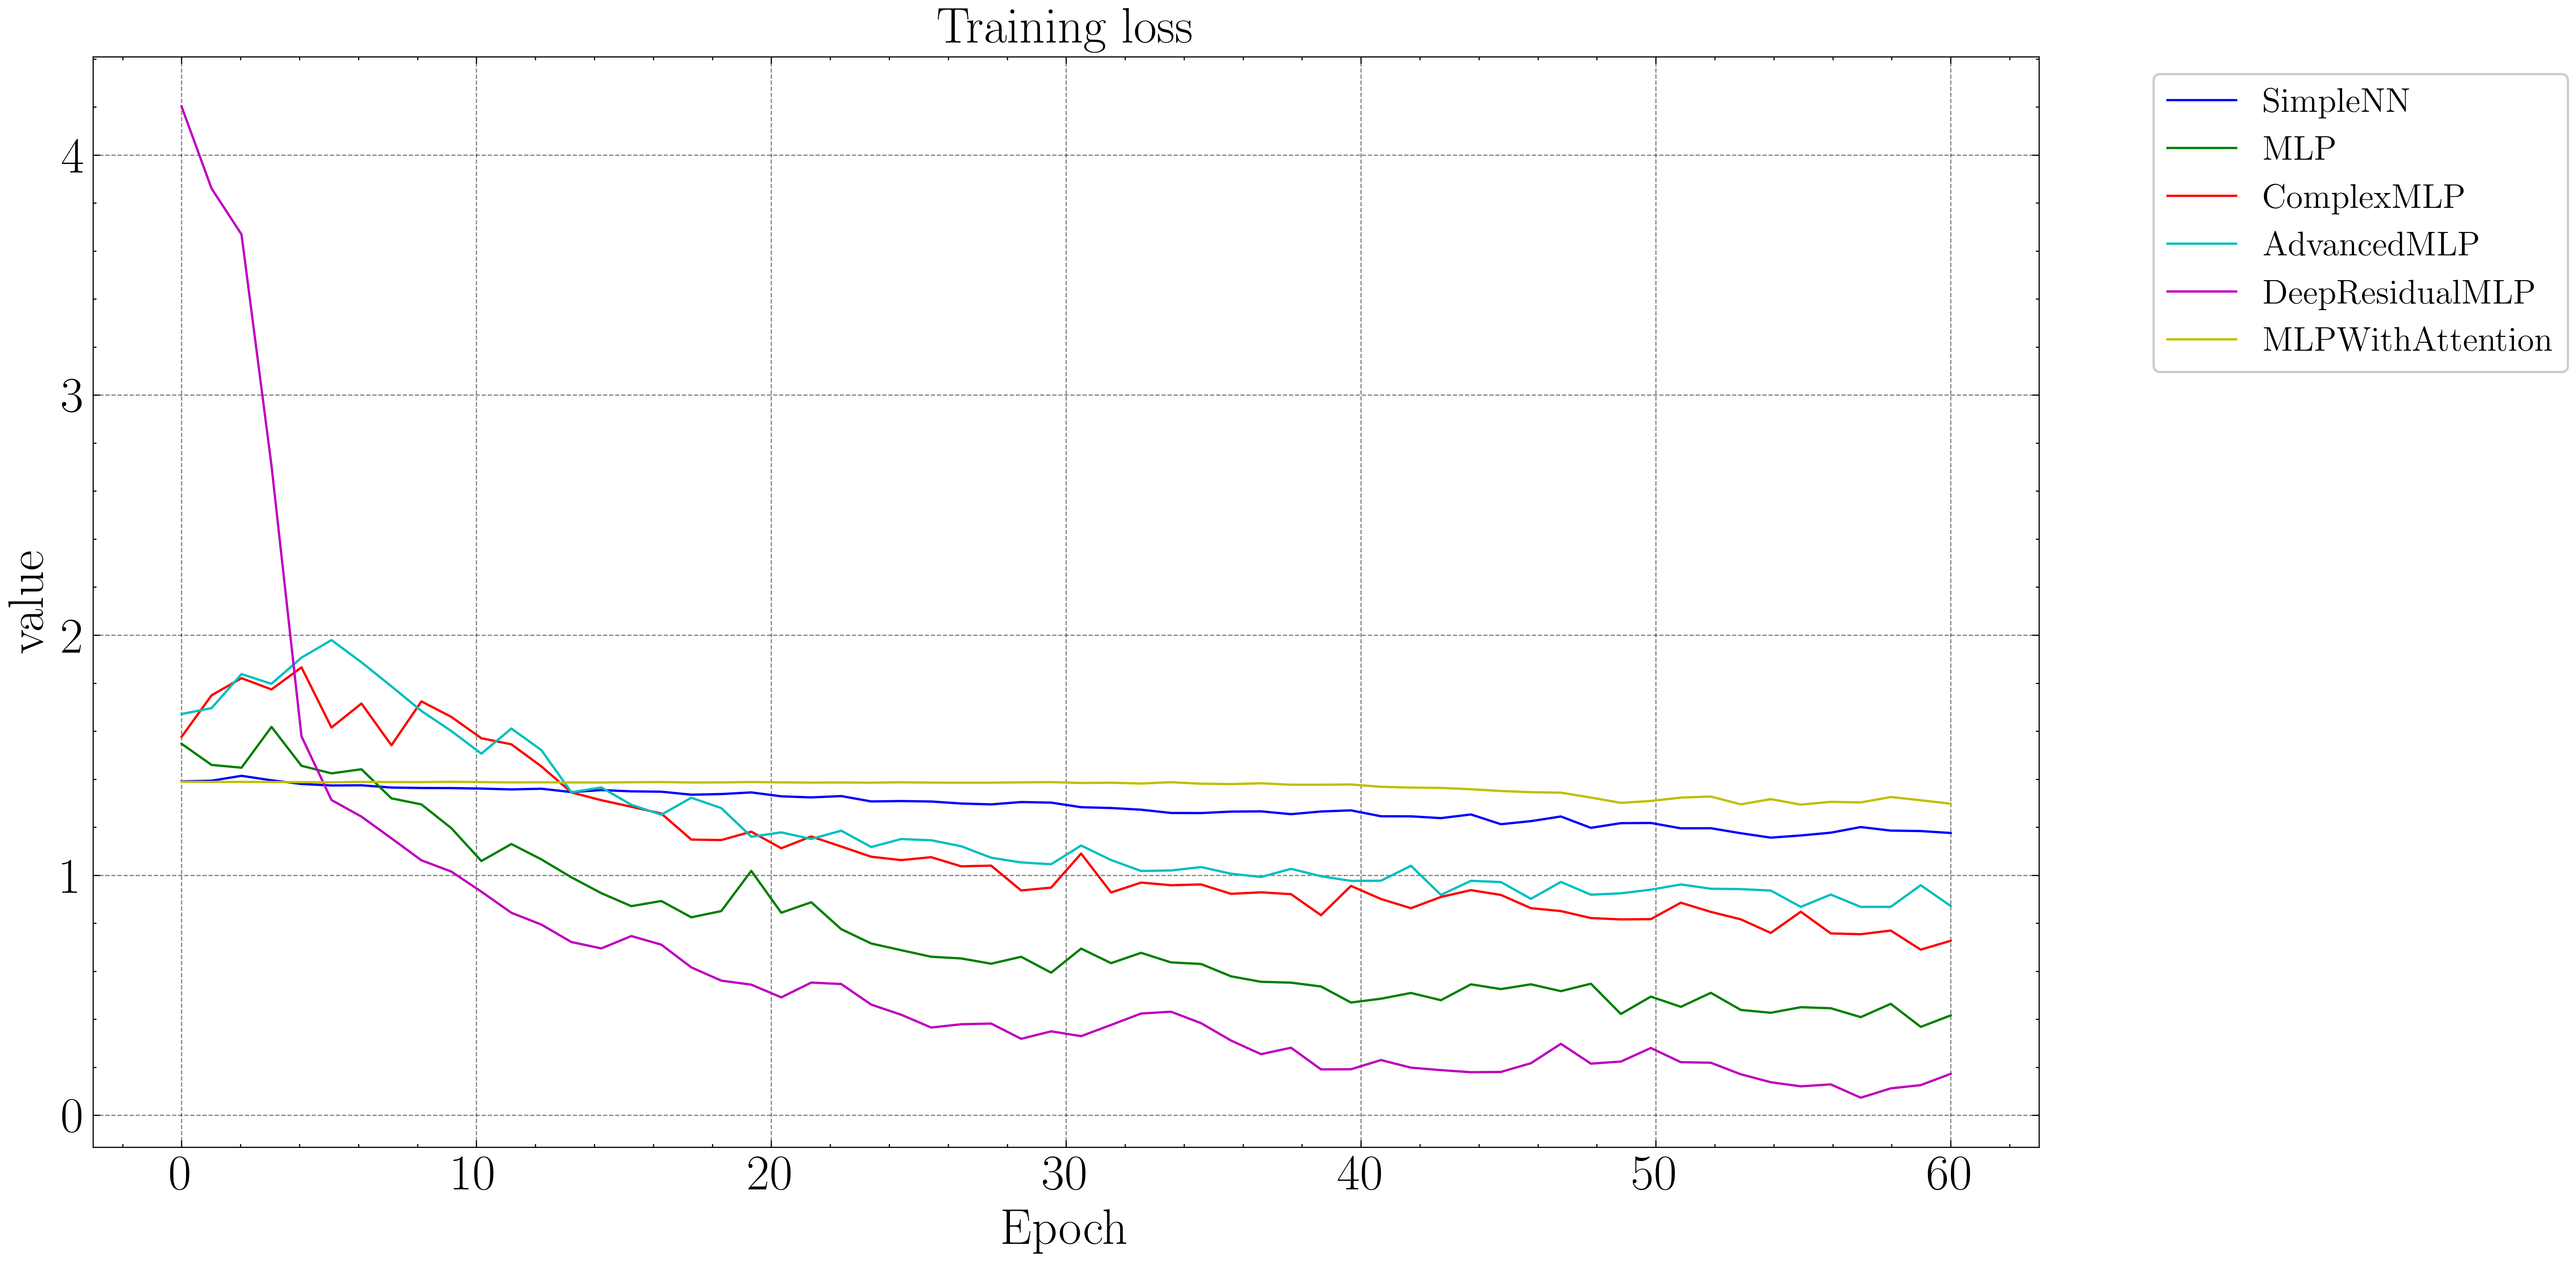

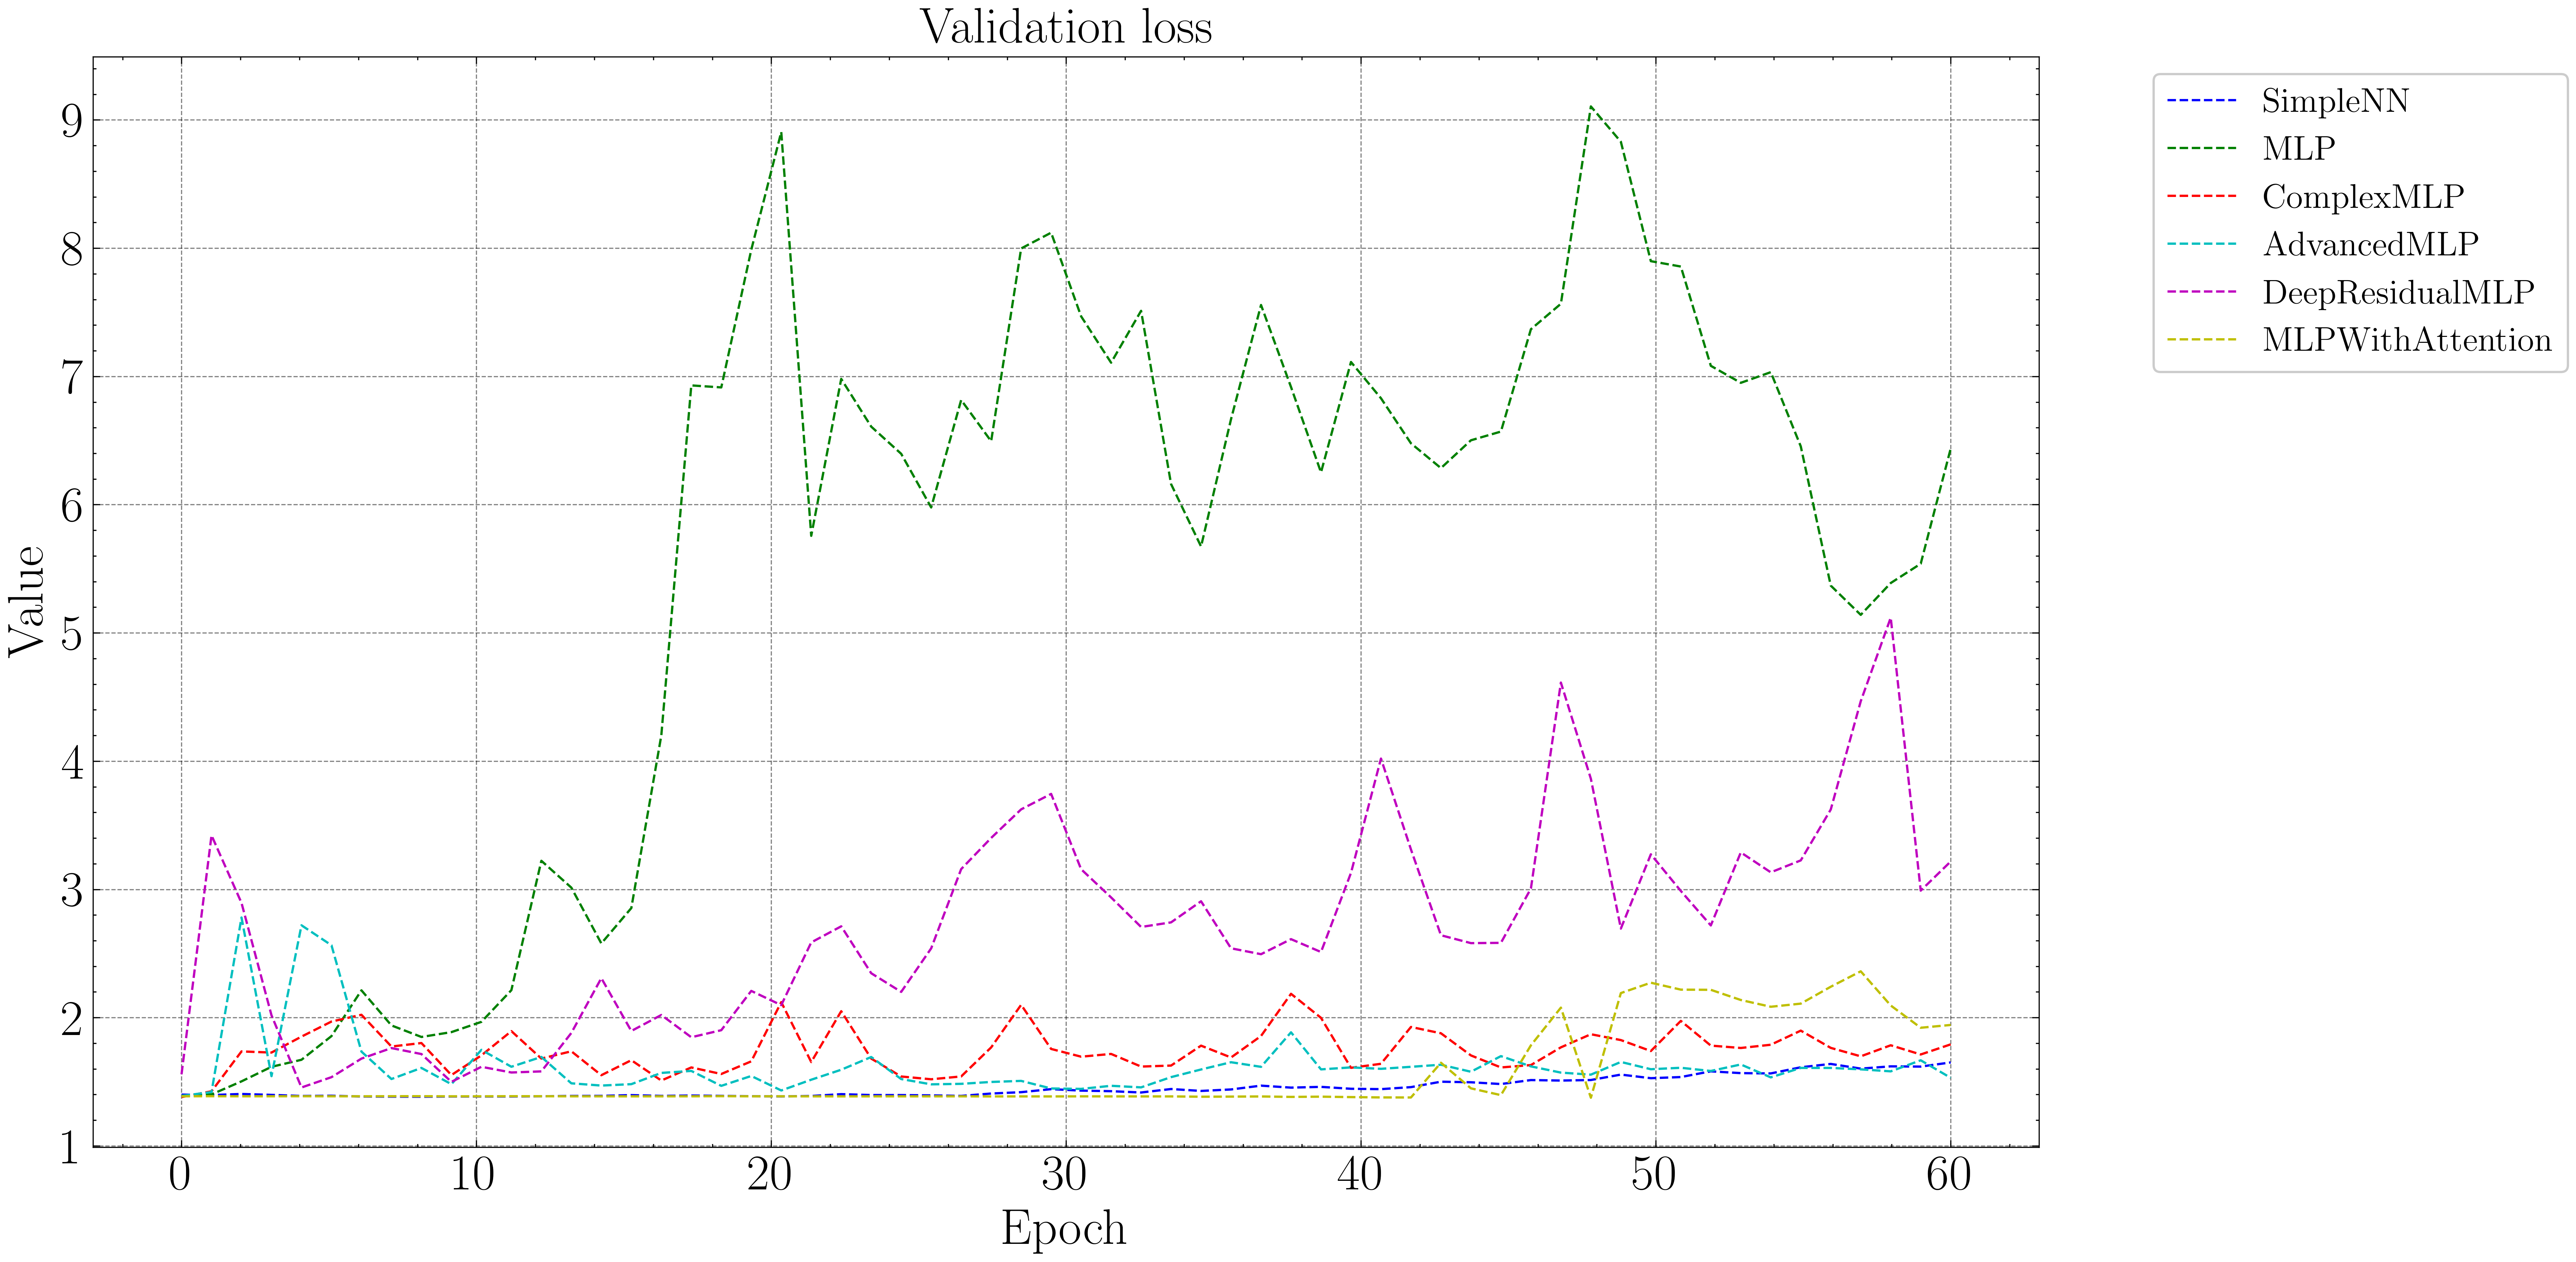

In [ ]:
names = []
for i in (range(len(models))):
    names.append(models[i].get_name())

available_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
colors = []
for i in range(len(models)):
    colors.append(available_colors[i])

def plot_train_losses(t_loss, names):
    plt.figure(figsize=(16, 8))
    for loss in range(len(t_loss)):

        y1 = t_loss[loss]

        x_values = np.linspace(0, epochs, len(t_loss[loss]))
        
        #plt.plot(x_values, y1, label="Training loss " + names[loss], color=colors[loss])
        plt.plot(x_values, y1, label= names[loss], color=colors[loss])
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("value")
    plt.grid(True)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path + '/train_loss_noaug.pdf')

    plt.show()

def plot_val_losses(v_loss, names):
    plt.figure(figsize=(16, 8))
    for loss in range(len(v_loss)):

        y2 = v_loss[loss]
        x_values = np.linspace(0, epochs, len(v_loss[loss]))

        plt.plot(x_values, y2, label= names[loss], color=colors[loss], linestyle="dashed")

    plt.title("Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path + '/val_loss_noaug.pdf')
    plt.show()

plot_train_losses(training_losses, names)
plot_val_losses(validation_losses, names)

Selected Best Model: DeepResidualMLP
Loaded best model from DeepResidualMLP_best_model_noaug.pth
Test Accuracy: 47.58%
Average Test Loss: 2.5606


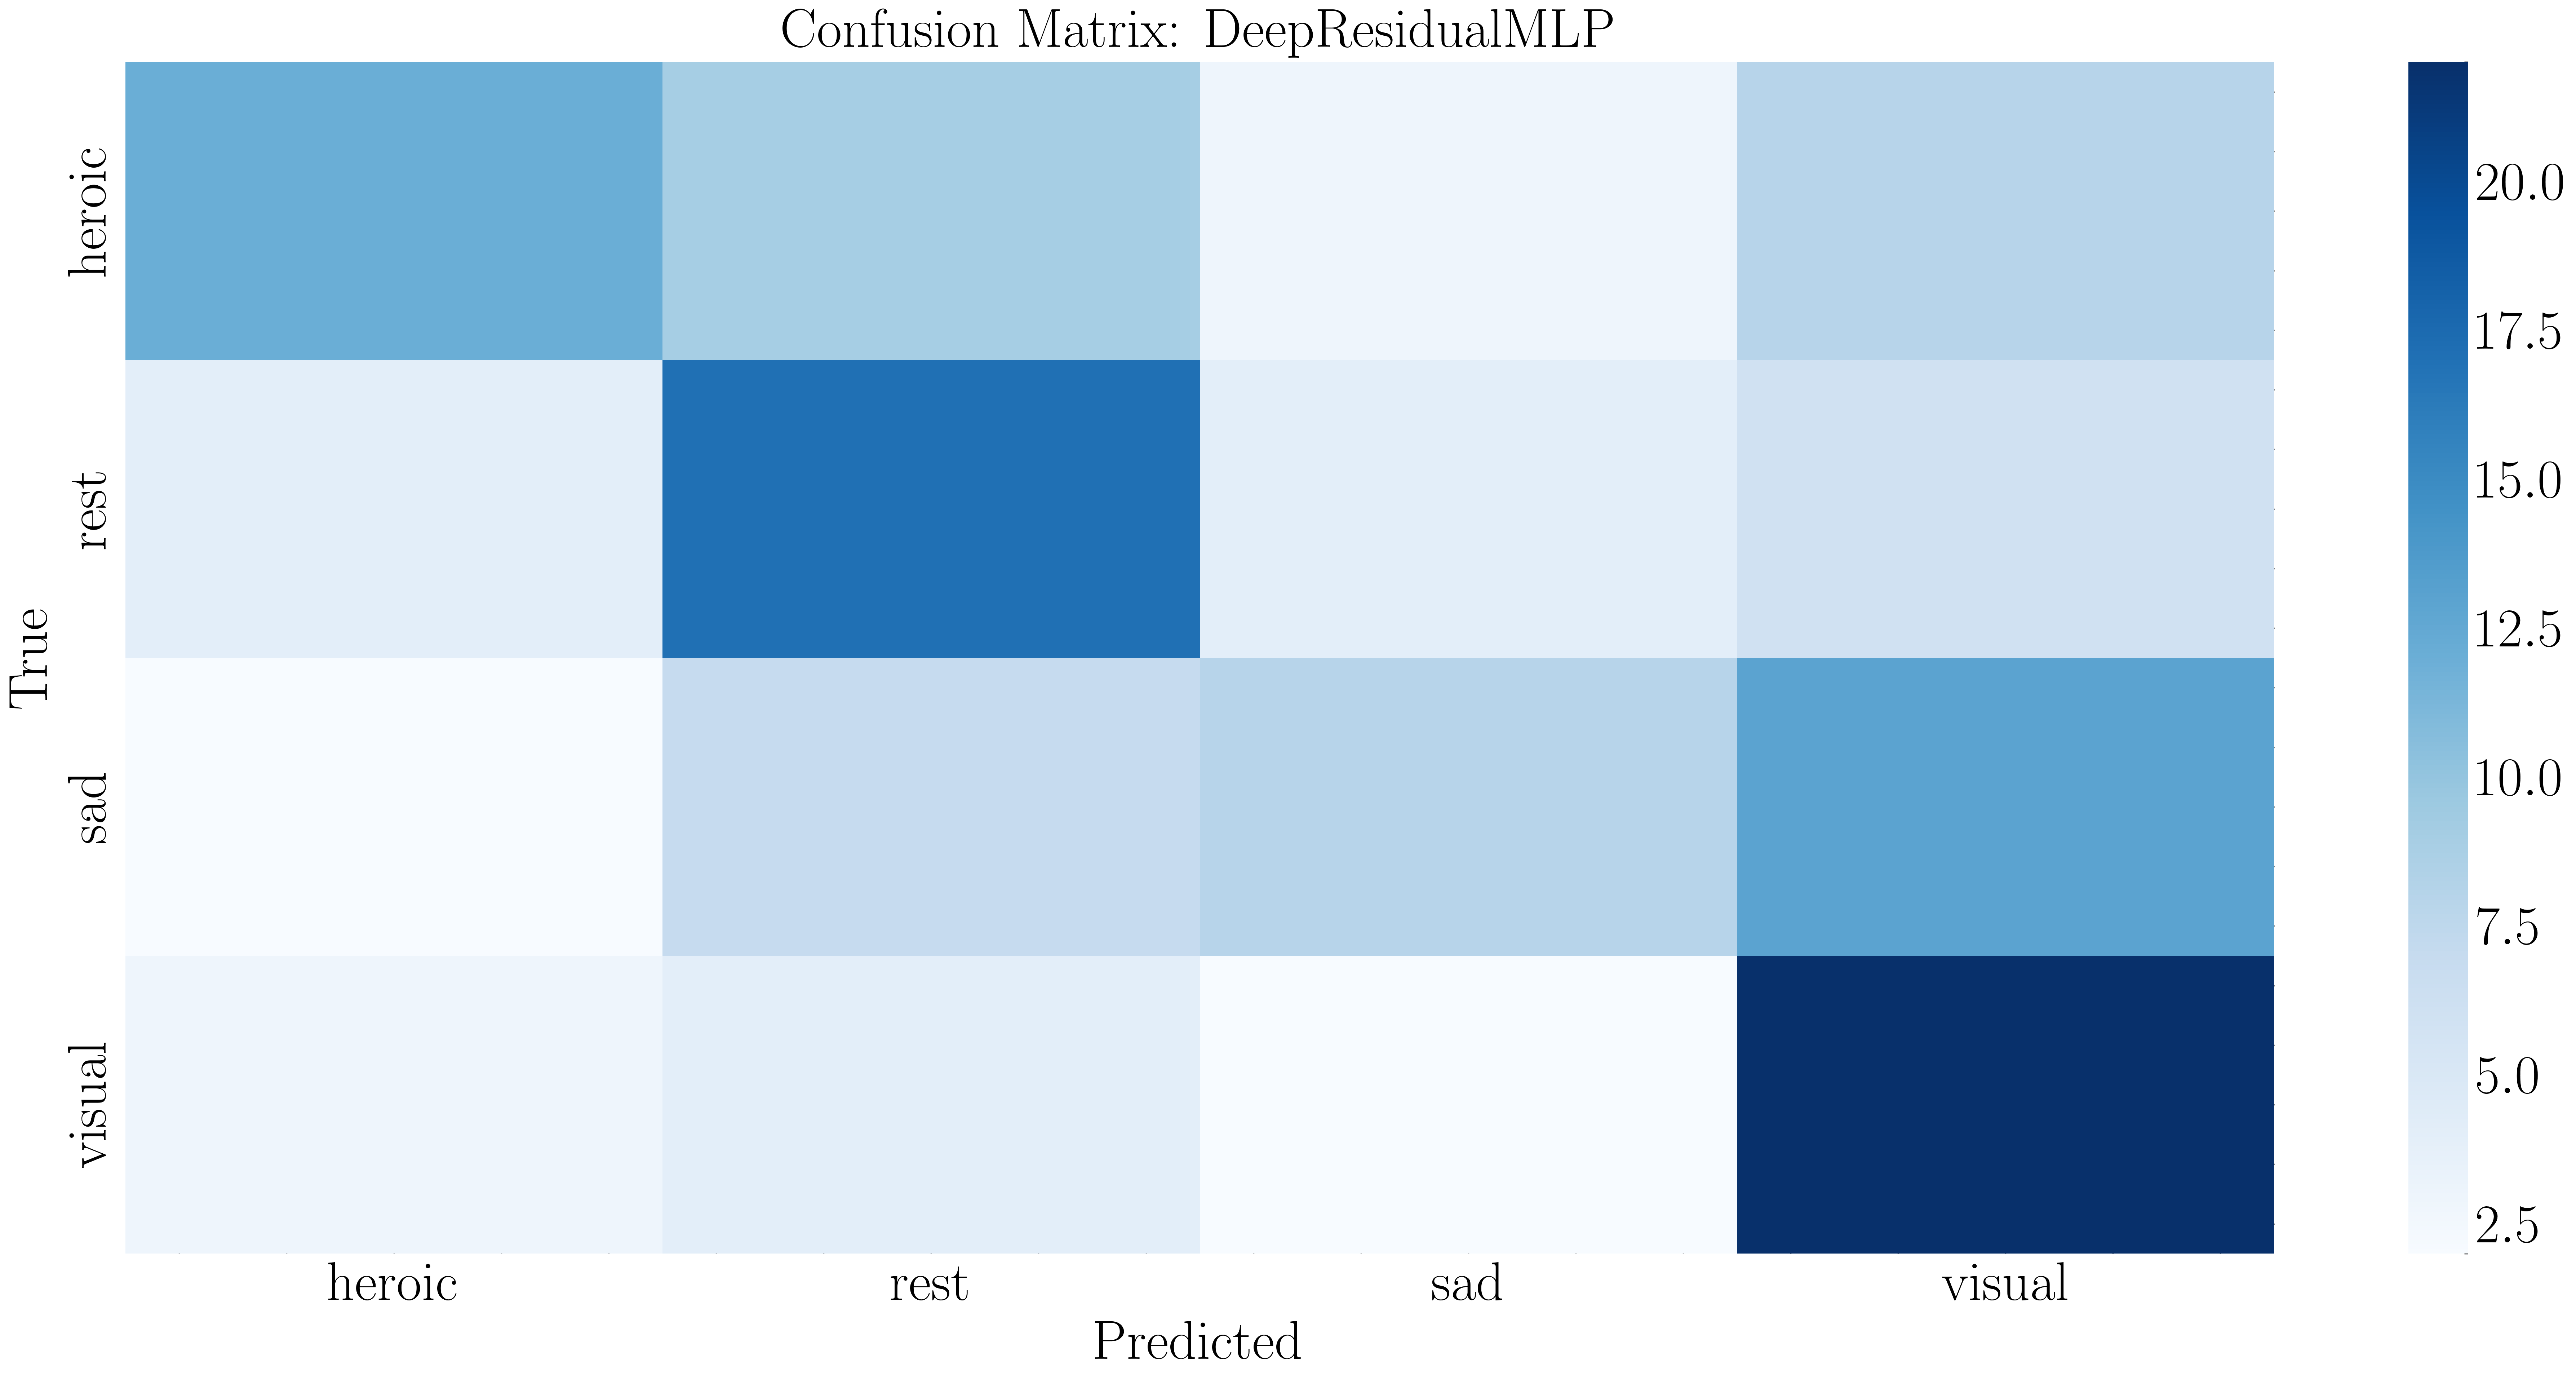

In [ ]:
model_classes = {'SimpleNN': SimpleNN, 'AdvancedMLP': AdvancedMLP, 'MLP': MLP, 'ComplexMLP': ComplexMLP, 
                 'MLPWithAttention': MLPWithAttention, 'DeepResidualMLP': DeepResidualMLP}

# Choose the best model based on the highest combined_scores value
best_model_dict = max(best_models, key=lambda x: x['combined_scores'])
print("Selected Best Model:", best_model_dict['model_name'])

# Get the corresponding model class
BestModelClass = model_classes[best_model_dict['model_name']]

# Instantiate the best model using its initialization parameters stored in the dictionary.
# For example, if it's an MLP, its 'model_init_params' might be: {'input_dim': 33, 'num_classes': 4}
best_model_loaded = BestModelClass(**best_model_dict['model_init_params'])
best_model_loaded.to(device)

# Load the trained parameters from the saved state_dict
state_dict_path = best_model_dict['state_dict_path']
best_model_loaded.load_state_dict(torch.load(state_dict_path))

# The best model is now ready for further evaluation or inference.
print(f"Loaded best model from {state_dict_path}")

losses, test_acc, all_labels, all_preds = test_model(best_model_loaded, test_loader, criterion)

print(f"Test Accuracy: {test_acc:.2f}%")

# Optionally, print loss statistics:
print(f"Average Test Loss: {np.mean(losses):.4f}")

cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix 
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Confusion Matrix: {best_model_dict['model_name']}")
plt.tight_layout()
plt.savefig(save_path + '/confmatrix1_noaug.pdf')

plt.show()


In [21]:
""" 

--- HYPERPARAMETER TUNING ---

"""

learning_rates = [0.001, 0.01, 0.1]
decays = [0.0001, 0.001, 0.01]
epoch = 100
momentums = [0.9, 0.95, 0.99]

# Containers for tracking overall best results
best_hyperparams = None
best_combined_metric = 0  # best combined metric achieved so far
best_model_summary = None

# Optional: lists to track losses across runs
training_losses = []
validation_losses = []


# Loop over each hyperparameter combination.
for lr in learning_rates:
    for decay in decays:
        # For each optimizer type; for SGD, loop over momentum values.
        for optimizer_type in ['Adam', 'SGD', 'Adadelta']:
            momentum_list = momentums if optimizer_type == 'SGD' else [None]
            for momentum in momentum_list:
                # Instantiate a new model instance using the best model's initialization parameters.
                model_instance = model_classes[best_model_dict['model_name']](
                    **best_model_dict['model_init_params']
                )
                model_instance.to(device)

                # Set up the optimizer based on type.
                if optimizer_type == 'Adam':
                    optimizer = optim.Adam(model_instance.parameters(), lr=lr, weight_decay=decay)
                    opt_details = f"Adam: lr={lr}, decay={decay}, epochs={epoch}"
                elif optimizer_type == 'SGD':
                    optimizer = optim.SGD(model_instance.parameters(), lr=lr, weight_decay=decay, momentum=momentum)
                    opt_details = f"SGD: lr={lr}, decay={decay}, epochs={epoch}, momentum={momentum}"
                elif optimizer_type == 'Adadelta':
                    optimizer = optim.Adadelta(model_instance.parameters(), lr=lr, weight_decay=decay)
                    opt_details = f"Adadelta: lr={lr}, decay={decay}, epochs={epoch}"
                
                print(f"\nTraining {model_instance.get_name()} with {opt_details}\n")

                # Train the model using your updated train function.
                results = train(
                    model=model_instance,
                    optimizer=optimizer,
                    criterion=criterion,
                    train_loader=train_loader,
                    validation_loader=val_loader,
                    epochs=epoch
                )

                # Optionally track losses over runs.
                training_losses.append(results['training_losses'])
                validation_losses.append(results['validation_losses'])

                # Retrieve the best model summary from this run.
                run_best_summary = results['best_model_summary']
                # Combined metric is the average of validation accuracy and f1_score
                combined_metric = run_best_summary['combined_scores'] #accuracy, f1_score combined_scores

                # If this run gives a better combined metric than before, update our best results.
                if combined_metric > best_combined_metric:
                    best_combined_metric = combined_metric
                    best_hyperparams = {
                        'learning_rate': lr,
                        'decay': decay,
                        'epochs': run_best_summary['epoch'],
                        'optimizer': optimizer_type,
                        'momentum': momentum  # Will be None for non-SGD optimizers.
                    }
                    best_model_summary_hpt = run_best_summary
                    print(f"New best model found: {model_instance.get_name()} with combined metric: {combined_metric:.2f} at epoch {best_model_summary_hpt['epoch']}")


Training DeepResidualMLP with Adam: lr=0.001, decay=0.0001, epochs=100

Epoch: 1, Train Loss: 1.5790, Val Loss: 1.3809, Val Acc: 29.84%, F1: 27.25%, Combined: 28.54%
Epoch: 20, Train Loss: 0.0861, Val Loss: 2.5063, Val Acc: 35.48%, F1: 34.26%, Combined: 34.87%
Epoch: 40, Train Loss: 0.0378, Val Loss: 3.0763, Val Acc: 35.48%, F1: 35.04%, Combined: 35.26%
Epoch: 60, Train Loss: 0.0261, Val Loss: 3.2889, Val Acc: 29.84%, F1: 28.99%, Combined: 29.41%
Epoch: 80, Train Loss: 0.0692, Val Loss: 3.1471, Val Acc: 33.06%, F1: 33.17%, Combined: 33.12%
Epoch: 100, Train Loss: 0.0517, Val Loss: 4.1504, Val Acc: 33.87%, F1: 33.55%, Combined: 33.71%
New best model found: DeepResidualMLP with combined metric: 40.15 at epoch 74

Training DeepResidualMLP with SGD: lr=0.001, decay=0.0001, epochs=100, momentum=0.9

Epoch: 1, Train Loss: 1.6284, Val Loss: 1.3883, Val Acc: 25.81%, F1: 11.76%, Combined: 18.78%
Epoch: 20, Train Loss: 0.4891, Val Loss: 2.2065, Val Acc: 35.48%, F1: 35.69%, Combined: 35.59%
Epoc

In [22]:
# Print the overall best hyperparameter tuning result.
print("\n--- Best Hyperparameter Tuning Result ---")
print(f"Model: {best_model_summary_hpt['model_name']}")
print(f"Epoch: {best_model_summary_hpt['epoch']}")
print(f"Accuracy: {best_model_summary_hpt['accuracy']:.2f}%")

print(f"F1 Score: {best_model_summary_hpt['f1_score']:.2f}%")
print(f"Combined Metric: {best_model_summary_hpt['combined_scores']:.2f}%")
print(f"Hyperparameters: {best_hyperparams}")
print(f"Saved state_dict path: {best_model_summary_hpt['state_dict_path']}")


--- Best Hyperparameter Tuning Result ---
Model: DeepResidualMLP
Epoch: 66
Accuracy: 48.39%
F1 Score: 48.39%
Combined Metric: 48.39%
Hyperparameters: {'learning_rate': 0.1, 'decay': 0.0001, 'epochs': 66, 'optimizer': 'SGD', 'momentum': 0.9}
Saved state_dict path: DeepResidualMLP_best_model_noaug.pth


Test Accuracy of the best model: DeepResidualMLP - 41.13%


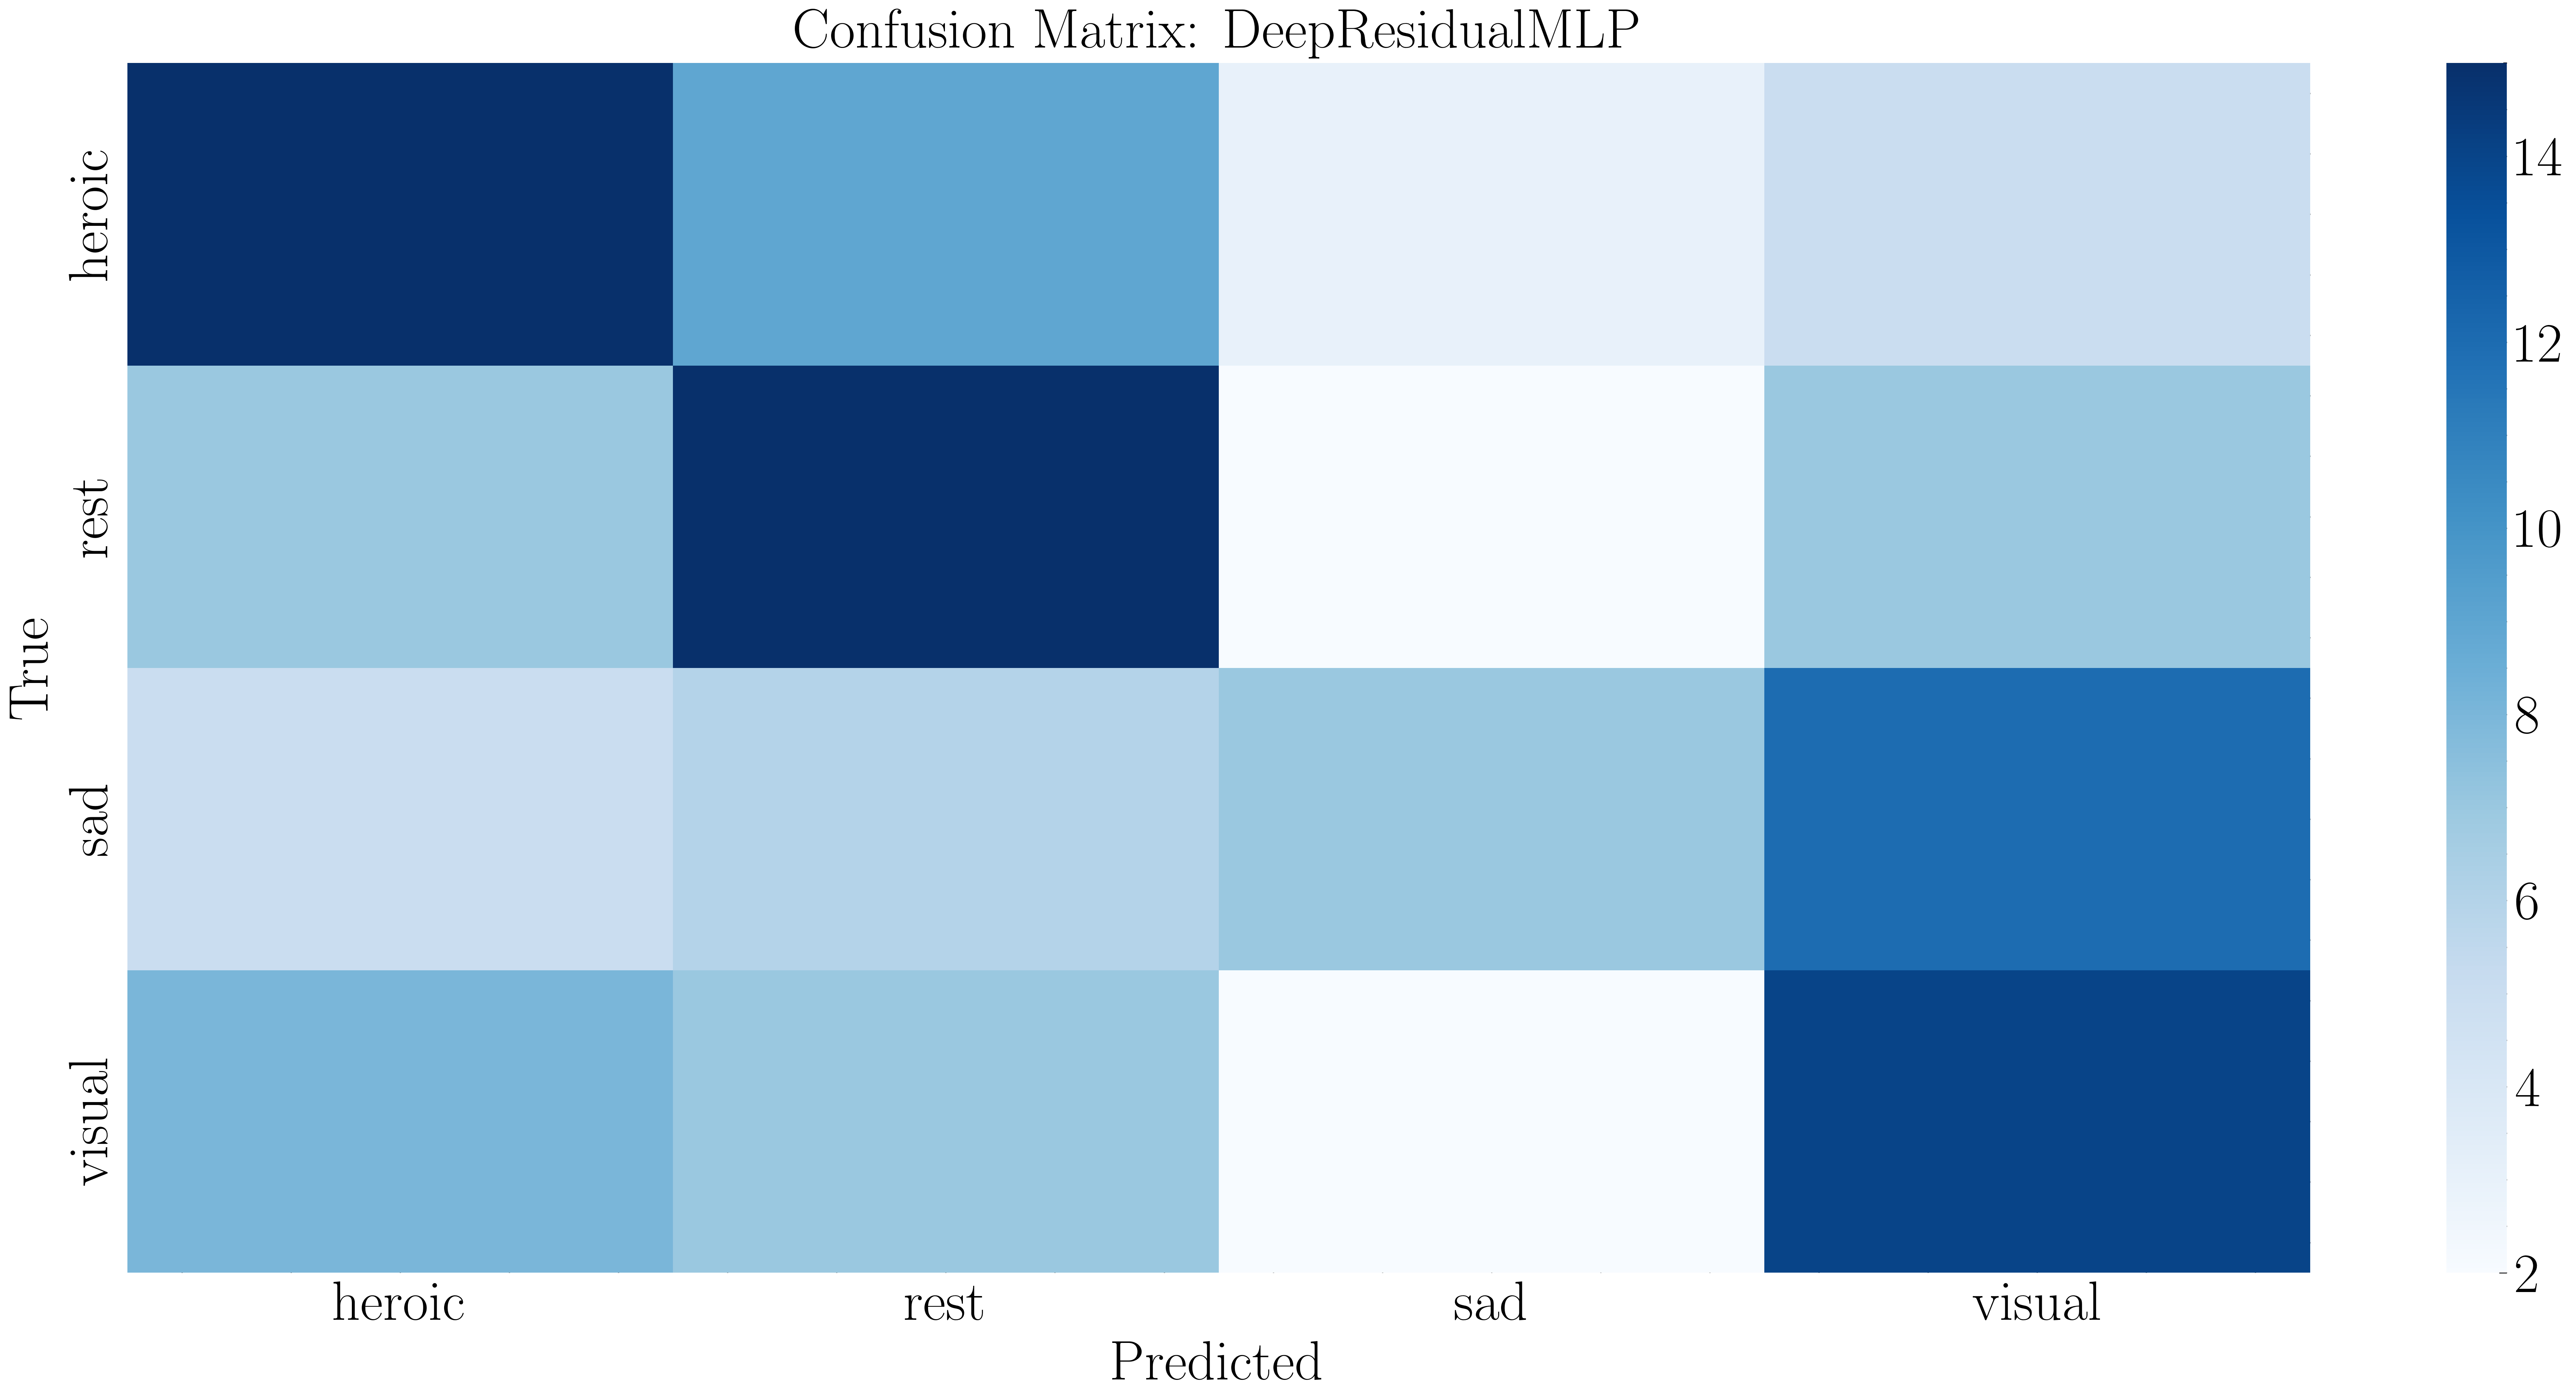

In [23]:
#load the best model for testing or inference:

BestModelClass = model_classes[best_model_summary_hpt['model_name']]

# Instantiate a new instance using the stored initialization parameters.
best_model_loaded = BestModelClass(**best_model_summary_hpt['model_init_params'])
best_model_loaded.load_state_dict(torch.load(best_model_summary_hpt['state_dict_path']))
best_model_loaded.to(device)

losses, accs, all_labels, all_preds = test_model(best_model_loaded, test_loader, criterion)

print(f"Test Accuracy of the best model: {best_model_summary_hpt['model_name']} - {accs:.2f}%")

cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Confusion Matrix: {best_model_summary_hpt['model_name']}")
plt.tight_layout()
plt.savefig(save_path + '/confmatrix2_noaug.pdf')

plt.show()
